In [1]:
from Gian_experimental.NSGAIICustom.CustomOperators import NCSamplerFromPRef, NCMutationCounterproductive, \
    NCCrossoverTransition
from Gian_experimental.NSGAIICustom.NSGAIICustom import EvaluatedNCSolution, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple
from scipy.stats import ks_2samp, wasserstein_distance
from Gian_experimental.NSGAIICustom.testing_in_vitro.testing_operators_in_vitro import make_metrics_cached

dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"
# dir_250 = r"/Users/gian/PycharmProjects/PSSearch/data/retail_forecasting/250"
import heapq
import itertools
import json
import random
from typing import Iterable, Optional, Iterator

import numpy as np

import utils
from Gian_experimental.NSGAIICustom.testing_in_vitro.SPRef import SPRef, OptimisedSPref
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities, get_transition_matrix
from PolishSystem.read_data import get_pRef_from_vectors
import os
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import get_transition_matrix
from typing import Iterable
import heapq

def in_250(path):
    return os.path.join(dir_250, path)

train_pRef = get_pRef_from_vectors(name_of_vectors_file=in_250("train_many_hot_vectors_250_qmc.csv"),
                                   name_of_fitness_file=in_250("train_fitness_250_qmc.csv"),
                                   column_in_fitness_file=2)
test_pRef = get_pRef_from_vectors(name_of_vectors_file=in_250("test_many_hot_vectors_250_qmc.csv"),
                                  name_of_fitness_file=in_250("test_fitness_250_qmc.csv"),
                                  column_in_fitness_file=2)

train_SPRef = OptimisedSPref.from_pRef(train_pRef)
test_SPRef = OptimisedSPref.from_pRef(test_pRef)

cluster_info_file_name = in_250(f"cluster_info_250_qmc.pkl")
similarities = gian_get_similarities(cluster_info_file_name)

n = 250

def keep_ones_with_most_samples(population: Iterable[EvaluatedNCSolution], quantity_required: int):
    return heapq.nsmallest(iterable=population, key=lambda x: x.fitnesses[0], n=quantity_required)

transition_matrix = get_transition_matrix(similarities)
custom_sampling = NCSamplerFromPRef.from_PRef(train_pRef)
custom_mutation = NCMutationCounterproductive(transition_matrix)
custom_crossover = NCCrossoverTransition(transition_matrix)

def atomicity(ps):
    if len(ps) < 2:
        return -1000
    else:
        linkages = [similarities[a, b] for a, b in itertools.combinations(ps, r=2)]
        return np.average(linkages)

traditional_sampling = NCSamplerSimple.with_average_quantity(3, genome_size=n)
traditional_mutation = NCMutationSimple(n)
traditional_crossover = NCCrossoverSimple(swap_probability=1 / n)




In [108]:
from Gian_experimental.NSGAIICustom.NSGAIICustom import NCSolution, NSGAIICustom

genome_threshold = 3

def get_metrics(ps: NCSolution) -> tuple[float]:
    # I will use sample size, variance and atomicity

    # for now, simplicity, mean fitness and atomicity
    simplicity_score = len(ps)
    matching, non_matching = train_SPRef.partition(ps, threshold=genome_threshold)
    #len_m, len_nm = len(matching), len(non_matching)
    #weighted_variance_score = (np.var(matching) * len_m + np.var(non_matching) * len_nm) / (len_m + len_nm)
    #mean_fitness = np.average(matching) if len(matching) > 0 else -1000
    median_diff = np.median(matching) - np.median(non_matching)
    #distance = wasserstein_distance(matching, non_matching) if min(len(matching), len(non_matching)) > 2 else 0
    #is_beneficial = np.average(matching) > np.average(non_matching)
    # if is_beneficial:
    #     distance *= -1
    #print(distance)
    atomicity_score = atomicity(ps)
    
    if len(matching) < 1000: # a constraint
        return 1000, 1000, 1000, 1000

    return (len(ps), -len(matching), -median_diff, -atomicity_score)

algorithm = NSGAIICustom(sampling=traditional_sampling,
                         mutation=traditional_mutation,
                         crossover=traditional_crossover,
                         probability_of_crossover=0.5,
                         eval_budget=5000,
                         pop_size=100,
                         tournament_size=3,
                         mo_fitness_function=make_metrics_cached(get_metrics),
                         unique=True,
                         verbose=True,
                         culler=keep_ones_with_most_samples
                         )

In [109]:
results  = algorithm.run()

NSGAIICustom -> Beginning of NC process


C:\Users\gac8\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


NSGAIICustom -> Used evals: 211
NSGAIICustom -> Used evals: 316
NSGAIICustom -> Used evals: 426
NSGAIICustom -> Used evals: 531
NSGAIICustom -> Used evals: 637
NSGAIICustom -> Used evals: 749
NSGAIICustom -> Used evals: 860
NSGAIICustom -> Used evals: 969
NSGAIICustom -> Used evals: 1074
NSGAIICustom -> Used evals: 1176
NSGAIICustom -> Used evals: 1284
NSGAIICustom -> Used evals: 1391
NSGAIICustom -> Used evals: 1498
NSGAIICustom -> Used evals: 1607
NSGAIICustom -> Used evals: 1722
NSGAIICustom -> Used evals: 1825
NSGAIICustom -> Used evals: 1936
NSGAIICustom -> Used evals: 2042
NSGAIICustom -> Used evals: 2159
NSGAIICustom -> Used evals: 2269
NSGAIICustom -> Used evals: 2377
NSGAIICustom -> Used evals: 2483
NSGAIICustom -> Used evals: 2588
NSGAIICustom -> Used evals: 2694
NSGAIICustom -> Used evals: 2805
NSGAIICustom -> Used evals: 2916
NSGAIICustom -> Used evals: 3023
NSGAIICustom -> Used evals: 3132
NSGAIICustom -> Used evals: 3236
NSGAIICustom -> Used evals: 3350
NSGAIICustom -> Us

There are 82 results
(18, -1991, -0.6489049529205063, -0.0008827966) 18
(14, -1277, -0.9003239319818782, -0.015602795) 14
(12, -1223, -0.6936970402582249, -0.030870304) 12
(11, -1156, -0.6774591914881805, -0.007896138) 11
(14, -1603, -0.7624852210476396, -0.014851474) 14
(11, -1210, -0.641232770081253, -0.018138317) 11
(12, -1432, -0.7307300847386127, -0.0011971855) 12
(13, -1360, -0.9000604420299515, -0.013665244) 13
(13, -1342, -0.7365508784398882, -0.019574689) 13
(16, -1792, -0.694055960431288, -0.021337874) 16
(13, -1462, -0.790996868099364, -0.017329125) 13
(13, -1517, -0.7329944029570485, -0.002382461) 13
(13, -1345, -0.809420208868181, -0.018609487) 13
(13, -1576, -0.658465032048419, -0.026093785) 13
(13, -1724, -0.5830337844237382, -0.015142817) 13
(13, -1648, -0.6581017484922758, -0.003898452) 13
(14, -1899, -0.5774709379942827, -0.012983155) 14
(12, -1272, -0.7694446636901808, -0.011589202) 12
(13, -1338, -0.7850248756391011, -0.02453235) 13
(13, -1268, -0.9277822885855672, 

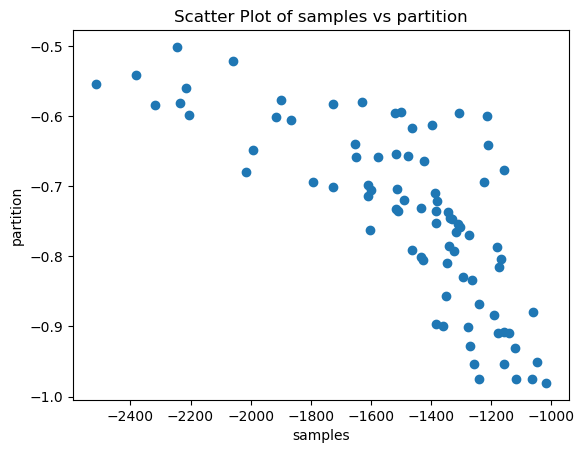

In [103]:
print(f"There are {len(results)} results")

for result in results:
    print(result.fitnesses, len(result.solution))
    
    
    
col_a = 1
col_b = 2
vals_a = [ps.fitnesses[col_a] for ps in results]
vals_b = [ps.fitnesses[col_b] for ps in results]

utils.simple_scatterplot(x_label="samples", y_label="partition", xs=vals_a, ys=vals_b)

In [104]:


from matplotlib import pyplot as plt
from Gian_experimental.plotting_utils import display_side_by_side

def compare_histograms(
    data1,
    data2,
    bins=30,
    log_x=False,
    log_y=False,
    labels=("Data 1", "Data 2"),
    title="Histogram Comparison",
    figsize=(6, 4),
    ax=None,
    y_axis_frequency="absolute",  # "absolute" or "relative"
):
    """
    Creates a histogram comparison plot of two datasets on a given Axes or a new figure.

    Parameters:
        ...
        y_axis_frequency (str): "absolute" for counts, "relative" for percentages (0–100%).

    Returns:
        matplotlib.figure.Figure or None
    """
    data1 = np.array(data1)
    data2 = np.array(data2)

    if log_x:
        data1 = data1[data1 > 0]
        data2 = data2[data2 > 0]
        combined = np.concatenate([data1, data2])
        min_val = combined.min()
        max_val = combined.max()
        bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = None

    density = y_axis_frequency == "relative"

    ax.hist(data1, bins=bins, alpha=0.5, label=labels[0], edgecolor='black', density=density)
    ax.hist(data2, bins=bins, alpha=0.5, label=labels[1], edgecolor='black', density=density)

    if log_x:
        ax.set_xscale('log')
    if log_y:
        ax.set_yscale('log')

    ax.set_xlabel("Value")
    ax.set_ylabel("Percentage" if density else "Frequency")

    if density:
        # Convert y-axis to percentage
        ticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])

    ax.set_title(title)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    return fig

def display_side_by_side(histogram_args_list, figsize_per_plot=(5, 5)):
    """
    Displays multiple histograms side-by-side using `compare_histograms`.

    Parameters:
        histogram_args_list (list[dict]): Each dict contains args for `compare_histograms`.
        figsize_per_plot (tuple): Size per individual plot; used to scale total figure.
    """
    num = len(histogram_args_list)
    total_figsize = (figsize_per_plot[0] * num, figsize_per_plot[1])
    fig, axs = plt.subplots(1, num, figsize=total_figsize)

    if num == 1:
        axs = [axs]  # Ensure it's iterable

    for args, ax in zip(histogram_args_list, axs):
        compare_histograms(ax=ax, **args)

    plt.tight_layout()
    plt.show()


def get_textual_description_of_distribution(values):
    return (f"n = {len(values)},\n"
              f"average = {np.average(values):.2f}, median = {np.median(values):.2f}\n"
              f"min = {np.min(values):.2f}, max = {np.max(values):.2f},\n")

def make_ps_into_explanation(ps, genome_threshold, test_SPref: SPRef):
    print(f"If you match at least {genome_threshold} items from this list of {len(ps)}:")
    print(ps)
    
    match_fitnesses, match_non_fitnesses = test_SPref.partition_using_threshold(ps, genome_threshold)
    distance = wasserstein_distance(match_fitnesses, match_non_fitnesses)
    if len(match_fitnesses) < 100:
        print("There are not enough matches!!!")
        return
    all_fitnesses = test_SPref.fitnesses
    
    print(f"The Wasserstein distance is {distance}")
    print("Distribution of match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_fitnesses)))
    print("Distribution of match fitness")
    print(utils.indent(get_textual_description_of_distribution(match_non_fitnesses)))
    
    display_side_by_side([
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Fitnesses of matches vs non-matches",
                "labels": ("Matches", "Non matches"),
                "y_axis_frequency": "relative"
            },
            {
                "data1": match_fitnesses,
                "data2": match_non_fitnesses,
                "title": f"Absolute view",
                "labels": ("Matches", "Non Matches"),
                "y_axis_frequency": "absolute"
            }
        ])

66 are satisfactory out of 82
The metrics were (18, -1991, -0.6489049529205063, -0.0008827966)
If you match at least 3 items from this list of 18:
{0, 66, 196, 132, 73, 208, 146, 211, 149, 213, 217, 219, 34, 35, 230, 49, 50, 121}
The Wasserstein distance is 0.6166421845529465
Distribution of match fitness
	n = 892,
	average = 3.77, median = 3.17
	min = -5.08, max = 16.60,
	
Distribution of match fitness
	n = 14940,
	average = 3.50, median = 3.28
	min = -7.22, max = 19.10,
	


C:\Users\gac8\AppData\Local\Temp\ipykernel_20156\1633460610.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


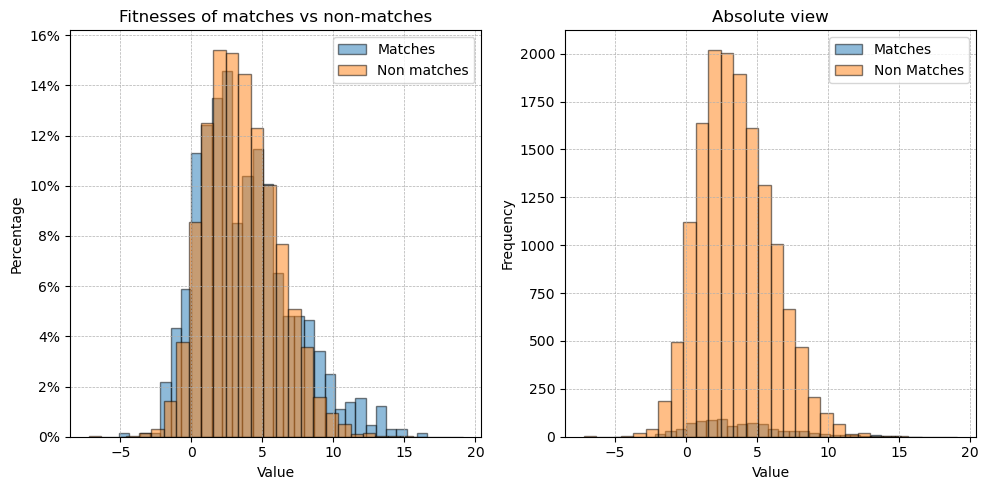

The metrics were (14, -1277, -0.9003239319818782, -0.015602795)
If you match at least 3 items from this list of 14:
{1, 196, 132, 164, 71, 73, 143, 208, 49, 211, 149, 182, 121, 219}
The Wasserstein distance is 0.648809058380508
Distribution of match fitness
	n = 577,
	average = 3.88, median = 3.50
	min = -5.08, max = 15.10,
	
Distribution of match fitness
	n = 15255,
	average = 3.51, median = 3.27
	min = -7.22, max = 19.10,
	


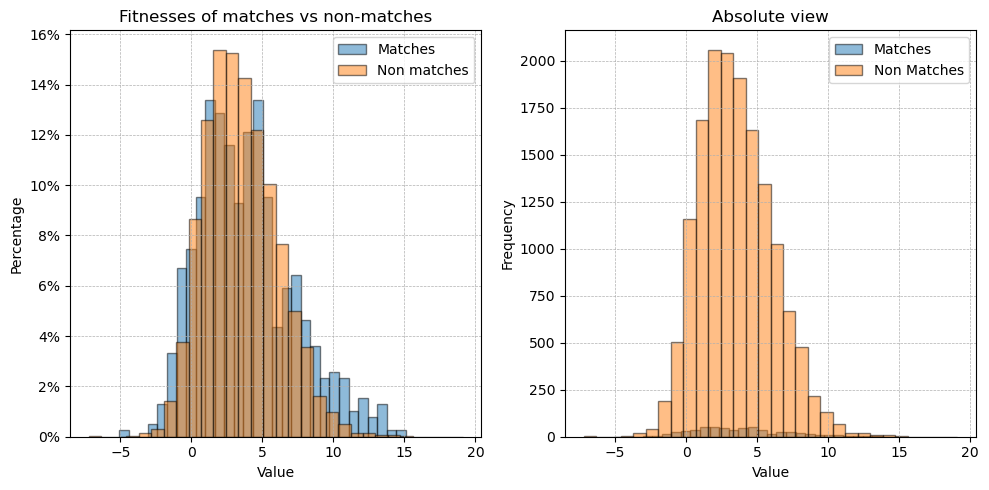

The metrics were (12, -1223, -0.6936970402582249, -0.030870304)
If you match at least 3 items from this list of 12:
{0, 98, 227, 101, 72, 104, 138, 107, 210, 20, 87, 121}
The Wasserstein distance is 0.5291556261105337
Distribution of match fitness
	n = 524,
	average = 3.74, median = 2.98
	min = -5.08, max = 15.10,
	
Distribution of match fitness
	n = 15308,
	average = 3.51, median = 3.28
	min = -7.22, max = 19.10,
	


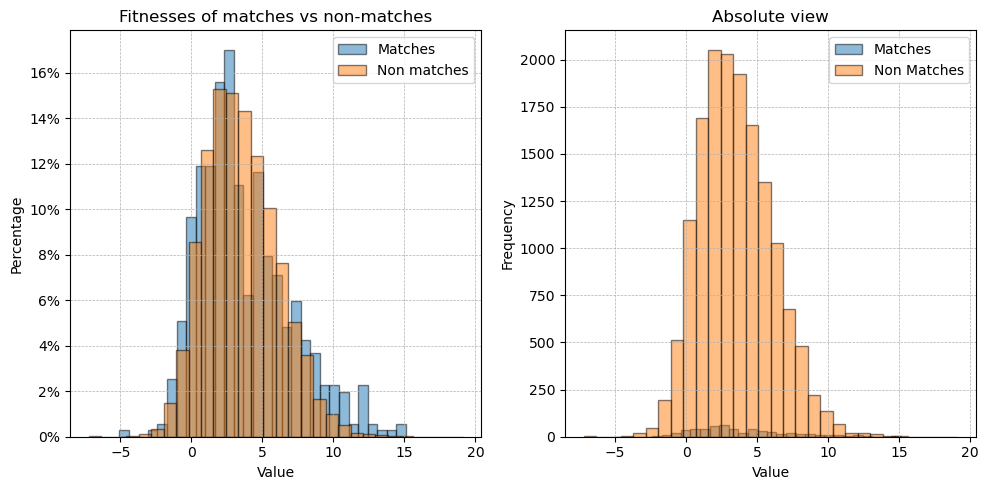

In [105]:
threshold_proportion_train = 0.1  # at least 10 %
threshold_quantity_train = round(len(train_SPRef.fitnesses) * threshold_proportion_train) 
def has_enough_matches_in_train(result_of_NSGAII: EvaluatedNCSolution):
    match_fitnesses, match_non_fitnesses = train_SPRef.partition_using_threshold(result_of_NSGAII.solution, 2)
    proportion = len(match_fitnesses) / len(train_SPRef.fitnesses)
    #print(proportion)
    return len(match_fitnesses) >= threshold_quantity_train

satisfactory_pss = list(filter(has_enough_matches_in_train, results))

print(f"{len(satisfactory_pss)} are satisfactory out of {len(results)}")
        

for result in satisfactory_pss[:3]:
    print(f"The metrics were {result.fitnesses}")
    make_ps_into_explanation(result.solution, genome_threshold=genome_threshold, test_SPref=test_SPRef)

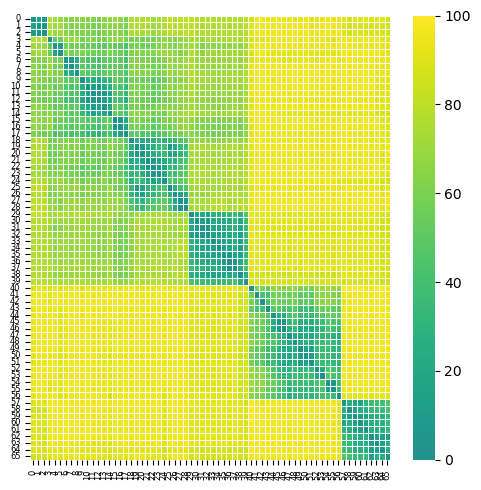

In [106]:


from initial_testing.rearrange_linkage_table import clean_table
from collections import defaultdict



def distance_function(a: set, b: set):
    return 100 * len(set.union(a, b) - a.intersection(b)) / len(set.union(a, b))
    

to_show = satisfactory_pss
quantity = len(to_show)
distance_matrix = np.zeros(shape=(quantity, quantity), dtype=int)
for i, j in itertools.combinations(range(quantity), r=2):
    distance_matrix[i, j] = distance_function(to_show[i].solution, to_show[j].solution)


distance_matrix += distance_matrix.T

utils.show_matrix_with_colours(clean_table(distance_matrix), fig_size=(5, 5))


# the table makes me think that #2 is different from everything else, so let's consider 0 and 2






    

C:\Users\gac8\AppData\Local\Temp\ipykernel_20156\1633460610.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ticks])


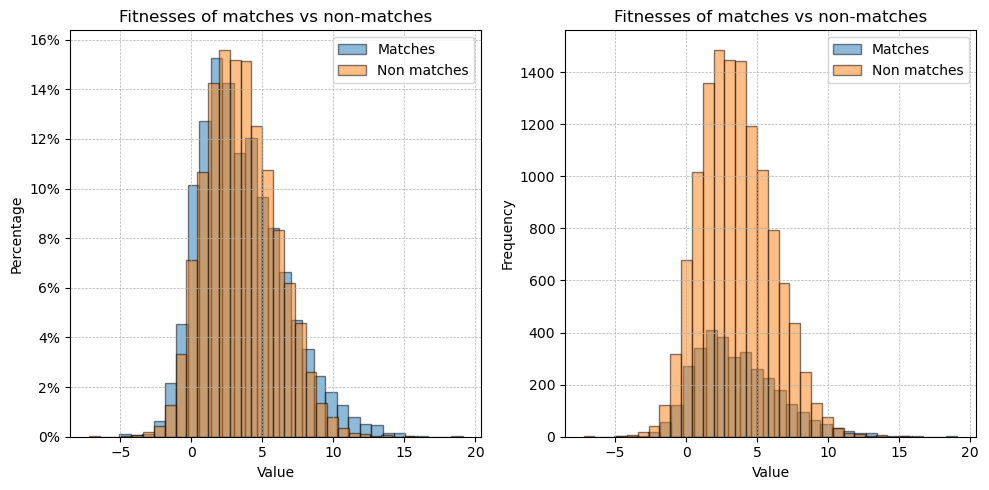

In [107]:
matches_by_any, non_matches_by_any = ([], [])


SPRef_to_get_from = test_SPRef
pss_to_consider =satisfactory_pss
for session, fitness in zip(SPRef_to_get_from.sessions, SPRef_to_get_from.fitnesses):
    def matches_pattern(run_result):
        return len(run_result.solution.intersection(session)) >=genome_threshold
    if any(map(matches_pattern, pss_to_consider)):
        matches_by_any.append(fitness)
    else:
        non_matches_by_any.append(fitness)


display_side_by_side([
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "relative"
    },
    {
        "data1": matches_by_any,
        "data2": non_matches_by_any,
        "title": f"Fitnesses of matches vs non-matches",
        "labels": ("Matches", "Non matches"),
        "y_axis_frequency": "absolute"
    },
])
            
    